# Active Learning Experiment Report

In dit verslag worden de resultaten gepresenteerd van een experimentele vergelijking tussen drie actieve leerstrategieën: **BatchBALD**, **BADGE** en **Random Sampling**. Het doel van dit experiment is om te analyseren welke strategie het meest efficiënt is in het verbeteren van modelprestaties met een beperkt aantal gelabelde voorbeelden.

De evaluatie is uitgevoerd op het **CIFAR-10** dataset, waarbij een **ResNet-18** model werd gebruikt. Per strategie zijn meerdere runs uitgevoerd, waarbij per iteratie het model opnieuw werd getraind met een uitgebreidere gelabelde subset.

---

## Overzicht van de strategieën

### Random Sampling
Bij elke iteratie worden willekeurig `n` datapunten geselecteerd uit de ongelabelde pool. Deze methode dient als referentiepunt om te beoordelen hoe goed de andere (informatieve) strategieën presteren.

### BADGE (Batch Active learning by Diverse Gradient Embeddings)
BADGE combineert informatierijke selectie met diversiteit. De methode maakt gebruik van de richting van de gradeint vector van de loss (zonder label) om informatieve voorbeelden te representeren, en gebruikt vervolgens **k-means++ clustering** om een diverse batch te selecteren.

Bron: Ash, J., & Adams, R. P. (2020). [Deep Batch Active Learning by Diverse, Uncertain Gradient Lower Bounds](https://arxiv.org/abs/1906.03671)

### BatchBALD
BatchBALD is een Bayesiaanse benadering van active learning. Het kiest een batch van datapunten die gezamenlijk **de meeste mutual information** verschaffen over de modelparameters. In tegenstelling tot gewone BALD, kijkt deze methode naar de **gezamenlijke informatiewaarde van een batch**, in plaats van individuele onzekerheden.

Bron: Kirsch, A., van Amersfoort, J., & Gal, Y. (2019). [BatchBALD: Efficient and Diverse Batch Acquisition for Deep Bayesian Active Learning](https://arxiv.org/abs/1906.08158)

---

## Doel van het rapport

In dit rapport worden per strategie de volgende aspecten vergeleken:

-  **Test accuracy** over iteraties (gemiddelde + standaarddeviatie)
-  **Iteratietijd** en totale experimentele tijd
-  **Samenvattende tabel** met eindresultaten


Alle resultaten zijn verzameld via **MLflow** en opgeslagen in een **SQLite-database (`mlflow.db`)**, die in dit notebook wordt uitgelezen en geanalyseerd.

---

*Laatste bewerking: automatisch gegenereerd op basis van geregistreerde experimenten in MLflow.*


In [46]:
# Setup (via SQLite i.p.v. mlruns/ directory)
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import mlflow

# Connect met mlflow.db
conn = sqlite3.connect("mlflow.db")

# Haal alle metric-entries met runinformatie op
runs_df = pd.read_sql('''
    SELECT r.run_uuid AS run_id, r.name as run_name, m.key, m.value, m.step
    FROM metrics m
    JOIN runs r ON m.run_uuid = r.run_uuid
''', conn)

# Pivot: metrics als kolommen
pivot_df = runs_df.pivot_table(index=["run_id", "run_name"], 
                                columns="key", 
                                values="value", 
                                aggfunc='max').reset_index()
pivot_df['strategy'] = pivot_df['run_name'].str.extract(r'^(.*)_resnet')
grouped = pivot_df.groupby('strategy')

In [47]:
valid_strategies = ["original_badge", "random", "uncertainty"]
runs_df = runs_df[runs_df['run_name'].str.extract(r'^(.*)_resnet')[0].isin(valid_strategies)]

## Groepeer runs per strategie

In [48]:
runs_df['strategy'] = runs_df['run_name'].str.extract(r'^(.*)_resnet')
grouped = runs_df.groupby('strategy')

## Test Accuracy per Iteratie

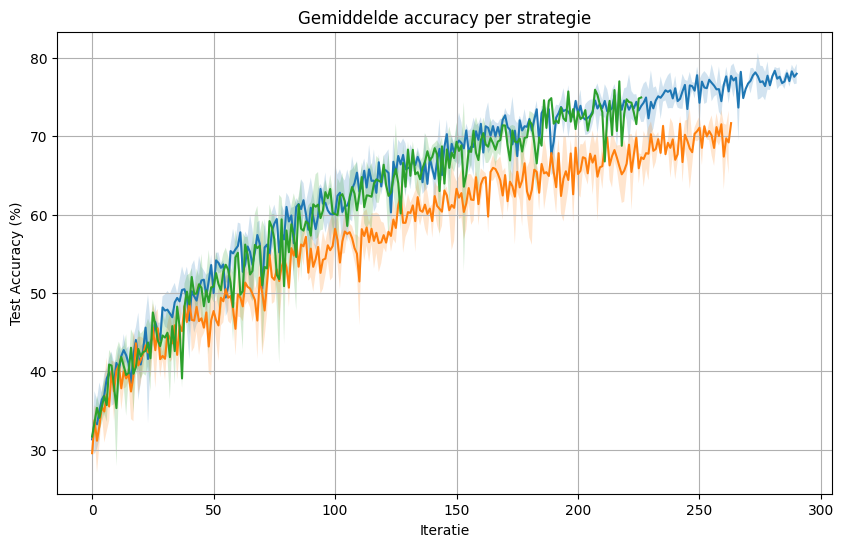

In [49]:
# Filter alleen accuracy-metrics (geen train_accuracy)
acc_df = runs_df[(runs_df['key'] == 'accuracy')]

plt.figure(figsize=(10, 6))

for strategy, group in acc_df.groupby(runs_df['strategy']):
    accs = []

    for run_id, run_group in group.groupby('run_id'):
        series = run_group.sort_values('step')['value'].reset_index(drop=True)
        accs.append(series)

    # Padding
    max_len = max(len(a) for a in accs)
    accs_padded = [a.tolist() + [None]*(max_len - len(a)) for a in accs]
    df = pd.DataFrame(accs_padded)

    plt.plot(df.mean(), label=strategy)
    plt.fill_between(df.columns, df.mean()-df.std(), df.mean()+df.std(), alpha=0.2)

plt.xlabel("Iteratie")
plt.ylabel("Test Accuracy (%)")
plt.title("Gemiddelde accuracy per strategie")
#plt.legend()
plt.grid()
plt.show()


## Iteratietijd per strategie

In [50]:
# Filter alleen iteratietijd metrics
it_df = runs_df[runs_df['key'].str.startswith('iteration_time')].copy()
it_df['iteration'] = it_df['key'].str.extract(r'iteration_time_(\d+)').astype(int)
it_df['strategy'] = it_df['run_name'].str.extract(r'^(.*)_resnet')

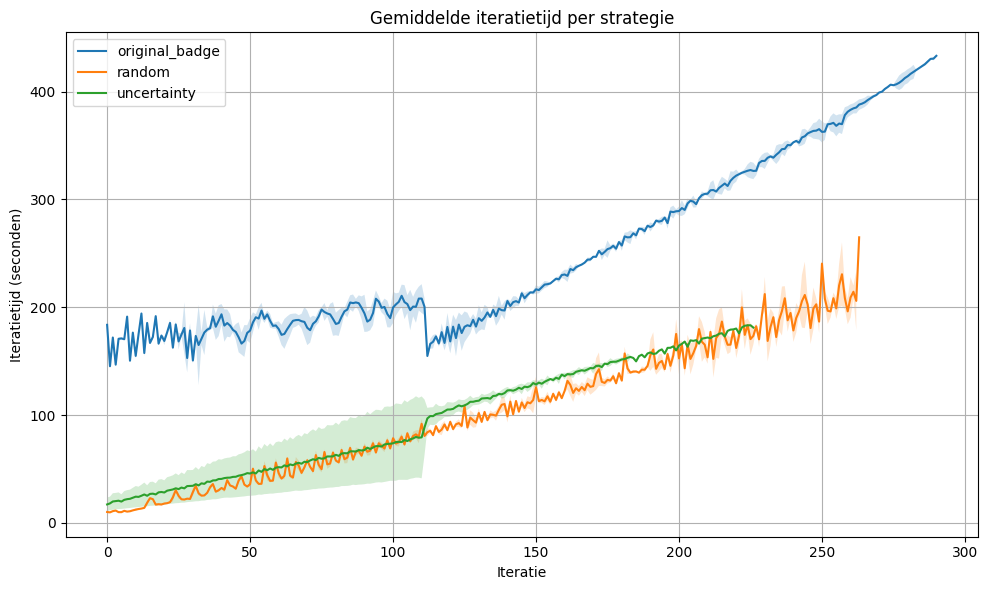

In [51]:
plt.figure(figsize=(10, 6))
for strategy, group in it_df.groupby('strategy'):
    grouped = group.groupby('iteration')['value']
    mean = grouped.mean()
    std = grouped.std()

    plt.plot(mean.index, mean.values, label=strategy)
    plt.fill_between(mean.index, mean - std, mean + std, alpha=0.2)

plt.xlabel("Iteratie")
plt.ylabel("Iteratietijd (seconden)")
plt.title("Gemiddelde iteratietijd per strategie")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


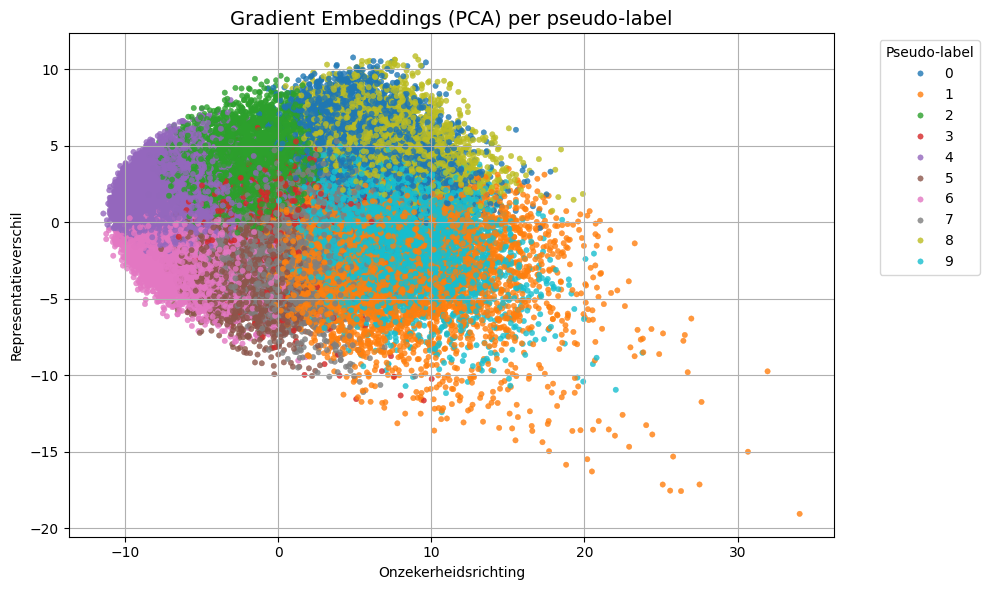

In [52]:
import torch
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Laad embeddings en pseudo-labels
data = torch.load("saved_embeddings_with_labels.pt")
embeddings = data["embeddings"]
labels = data["pseudo_labels"]

# PCA naar 2D
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings.numpy())

# Maak een dataframe voor Seaborn
df = pd.DataFrame({
    "PC1": reduced[:, 0],
    "PC2": reduced[:, 1],
    "label": labels.numpy()
})

# Plot met seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="PC1", y="PC2",
    hue="label",
    palette="tab10",  # Kies een andere als je wilt zoals "Spectral", "Set2", "deep"
    s=15, alpha=0.8,
    edgecolor=None
)
plt.title("Gradient Embeddings (PCA) per pseudo-label", fontsize=14)
plt.xlabel("Onzekerheidsrichting")
plt.ylabel("Representatieverschil")
plt.legend(title="Pseudo-label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


Aantal geselecteerde centers: 4
Geselecteerde indices: [3273, 36483, 16060, 41583]


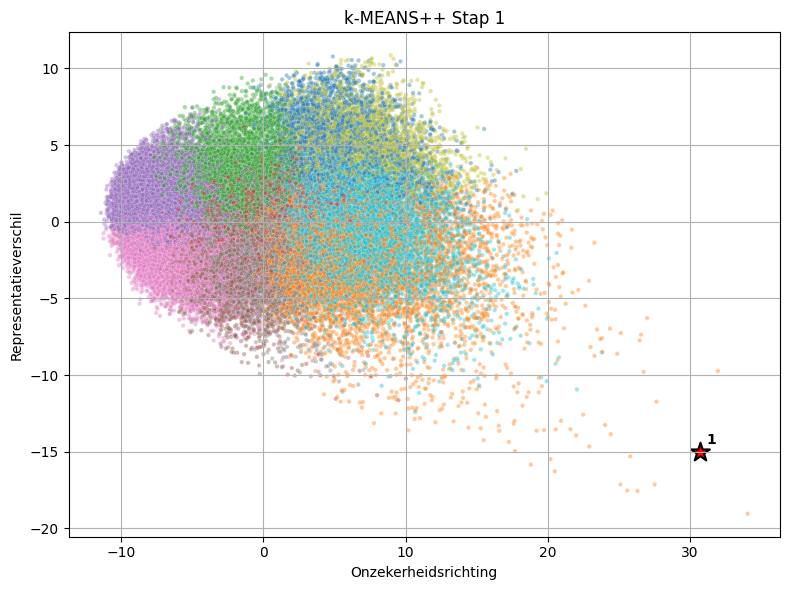

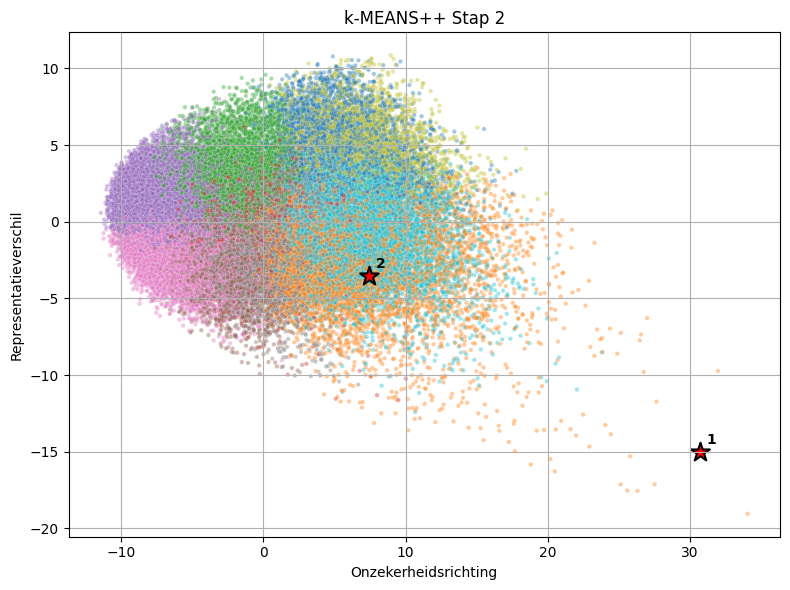

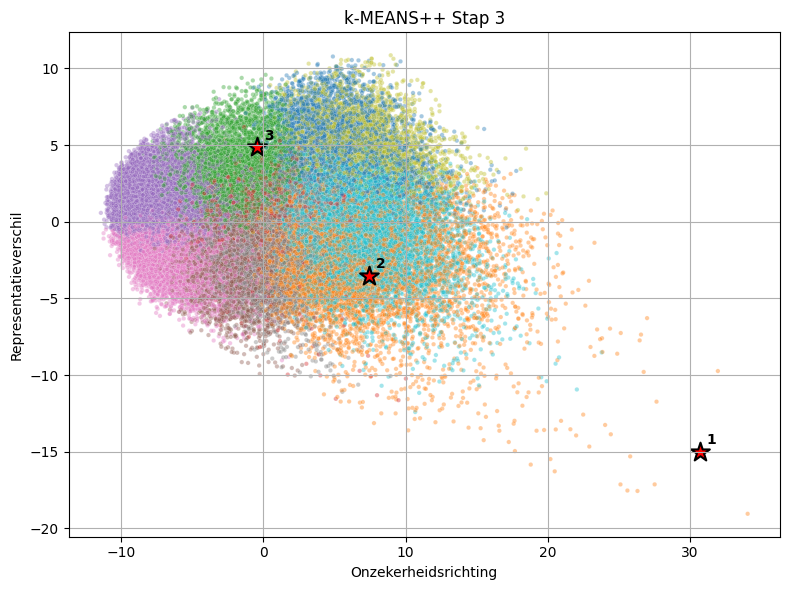

/tmp/ipykernel_66828/2221692159.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


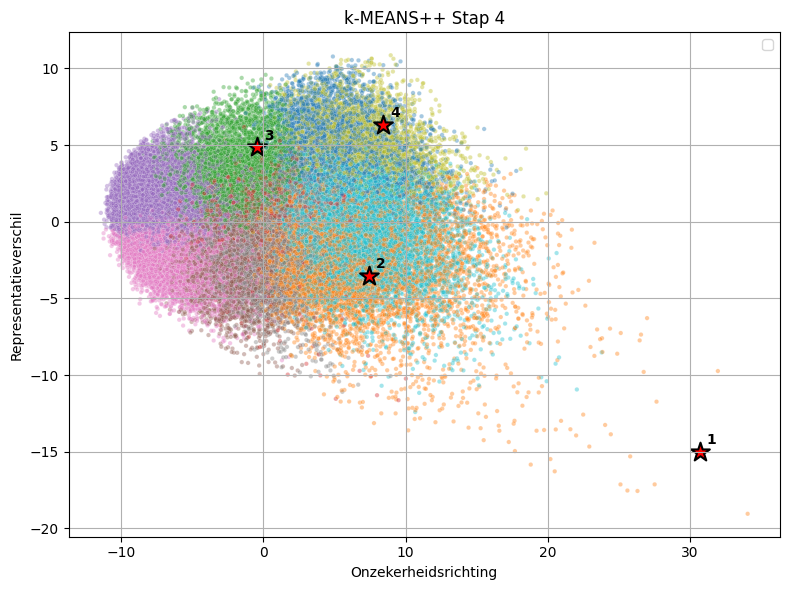

In [53]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin
import numpy as np

# Laad de opgeslagen gegevens
data = torch.load("kmeans_plus_plus_steps_500.pt")
embeddings = data["embeddings"]
pseudo_labels = data["pseudo_labels"]
selected = data["selected_indices"]

# PCA-reductie
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings.numpy())

# Zorg dat alle gekozen indices geldig zijn
selected_filtered = [i for i in selected if i < len(reduced)]

# Teken cumulatief per stap met lijnen naar dichtsbijzijnde center
print("Aantal geselecteerde centers:", len(selected_filtered))
print("Geselecteerde indices:", selected_filtered)

for i in range(min(len(selected_filtered), 4)):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=pseudo_labels.numpy(),
                    palette="tab10", legend=False, alpha=0.4, s=10)

    # Toon cumulatieve gekozen centers
    centers = np.array([reduced[selected_filtered[j]] for j in range(i + 1)])
    for j in range(i + 1):
        center = reduced[selected_filtered[j]]
        plt.scatter(center[0], center[1], c="red", s=200, marker="*", 
                    edgecolors="black", linewidths=1.5)
        plt.text(center[0] + 0.5, center[1] + 0.5, f"{j+1}", fontsize=10, fontweight='bold')


    # Bereken toewijzingen van een subset van de data aan centers
    subset_idx = np.random.choice(len(reduced), size=300, replace=False)
    closest = pairwise_distances_argmin(reduced[subset_idx], centers)


    plt.title(f"k-MEANS++ Stap {i+1}")
    plt.xlabel("Onzekerheidsrichting")
    plt.ylabel("Representatieverschil")
    if i == len(selected_filtered) - 1:
        plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


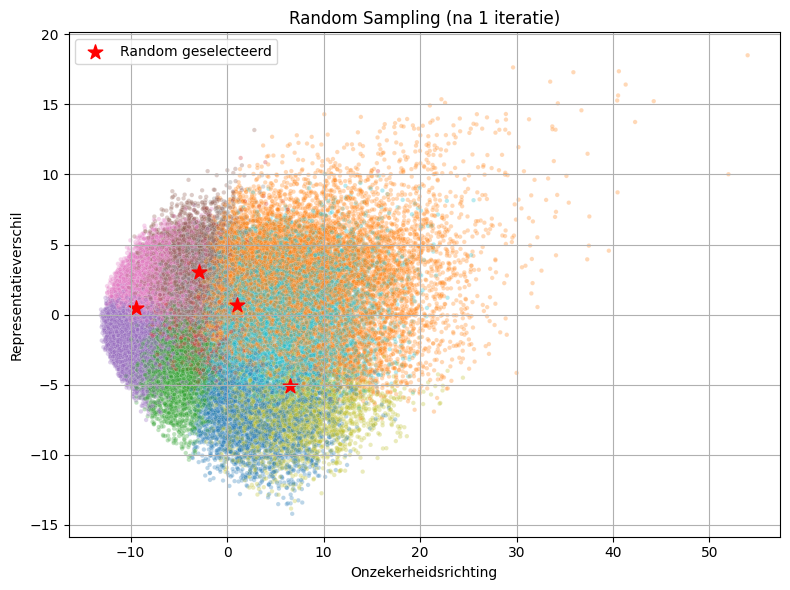

In [54]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Laad opgeslagen plotgegevens
data = torch.load("random_sampling_plot.pt")
embeddings = data["embeddings"]
pseudo_labels = data["pseudo_labels"]
selected = data["selected_indices"]

# Reduceer naar 2D met PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings.numpy())

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=reduced[:, 0], y=reduced[:, 1],
    hue=pseudo_labels.numpy(),
    palette="tab10", legend=False, alpha=0.3, s=10
)

# Highlight de geselecteerde punten
selected_coords = reduced[selected]
plt.scatter(selected_coords[:, 0], selected_coords[:, 1],
            c="red", s=120, marker="*", label="Random geselecteerd")

plt.title("Random Sampling (na 1 iteratie)")
plt.xlabel("Onzekerheidsrichting")
plt.ylabel("Representatieverschil")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [55]:
# Export dit notebook naar PDF (voeg alleen uit in een .ipynb notebook)
#!jupyter nbconvert --to pdf active_learning_report_sqlite.ipynb --output "active_learning_report.pdf"
